In [15]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Import Dependencies

In [16]:
# misc
import math
import time
from pathlib import Path

# scientific
import numpy as np
import beatbrain
from beatbrain import utils

# visualization
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [27]:
# Tensorflow
import tensorflow as tf

from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras import backend
from tensorflow.keras import optimizers

from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Dense,
    Lambda,
    Reshape,
    Flatten,
    Layer,
)
from tensorflow.keras.callbacks import (
    Callback,
    TensorBoard,
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TerminateOnNaN,
    CSVLogger,
    LambdaCallback,
)

<IPython.core.display.Javascript object>

In [19]:
sns.set()
sns.set_style("white")
%matplotlib inline

<IPython.core.display.Javascript object>

In [20]:
# Input
DATA_ROOT = Path("../data/fma/image")
IMAGE_DIMS = [512, 640, 1]
BATCH_SIZE = 4

<IPython.core.display.Javascript object>

In [21]:
train_dataset = utils.load_dataset(
    DATA_ROOT / "train", batch_size=BATCH_SIZE, parallel=False
)
val_dataset = utils.load_dataset(
    DATA_ROOT / "val", batch_size=BATCH_SIZE, parallel=False,
)
test_dataset = utils.load_dataset(
    DATA_ROOT / "test", batch_size=1, parallel=False, shuffle_buffer=0,
)

Checking input type(s) in '/media/data/beatbrain_data/fma/image/train'...
Determined input type to be 'IMAGE'
Checking input type(s) in '/media/data/beatbrain_data/fma/image/val'...
Determined input type to be 'IMAGE'
Checking input type(s) in '/media/data/beatbrain_data/fma/image/test'...
Determined input type to be 'IMAGE'


<IPython.core.display.Javascript object>

In [28]:
def build_cvae(latent_dim, input_shape, num_conv=2, batch_size=1, learning_rate=1e-4):
    def reparam(args):
        z_mean, z_log_var = args
        dim = tf.keras.backend.int_shape(z_mean)[1]
        eps = tf.keras.backend.random_normal(shape=(batch_size, dim))
        return eps * tf.exp(z_log_var * 0.5) + z_mean

    class Conv1DTranspose(Layer):
        def __init__(self, filters, kernel_size, strides=1, *args, **kwargs):
            self._filters = filters
            print(self._filters)
            self._kernel_size = (1, kernel_size)
            self._strides = (1, strides)
            self._args, self._kwargs = args, kwargs
            super(Conv1DTranspose, self).__init__()

        def build(self, input_shape):
            self._model = Sequential()
            self._model.add(Lambda(reshape_2d, batch_input_shape=input_shape))
            self._model.add(
                Conv2DTranspose(
                    self._filters,
                    kernel_size=self._kernel_size,
                    strides=self._strides,
                    *self._args,
                    **self._kwargs
                )
            )
            self._model.add(Lambda(lambda x: x[:, 0]))
            super(Conv1DTranspose, self).build(input_shape)

        def call(self, x):
            return self._model(x)

        def compute_output_shape(self, input_shape):
            return self._model.compute_output_shape(input_shape)

    encoder_input = Input(shape=input_shape, batch_size=batch_size)
    e = Lambda(reshape_1d)(encoder_input)  # (batch_size, time, freq)
    e = Conv1D(filters=3, kernel_size=3, strides=2, padding="SAME", activation="relu")(
        e
    )
    for i in range(num_conv):
        e = Conv1D(
            filters=6, kernel_size=3, strides=2, padding="SAME", activation="relu"
        )(e)
    decoder_input_shape = tf.keras.backend.int_shape(e)
    e = Flatten()(e)
    e = Dense(latent_dim * 2)(e)  # (batch_size, latent_dim*2)
    z_mean = Dense(latent_dim)(e)
    z_log_var = Dense(latent_dim)(e)
    z = Lambda(reparam, output_shape=(latent_dim,))(
        [z_mean, z_log_var]
    )  # (batch_size, latent_dim)
    encoder = Model(encoder_input, [z_mean, z_log_var, z], name="Encoder")

    decoder_input = Input(shape=(latent_dim,))
    d = Dense(decoder_input_shape[1] * decoder_input_shape[2], activation="relu",)(
        decoder_input
    )
    d = Reshape(target_shape=(decoder_input_shape[1], decoder_input_shape[2]))(d)
    for i in range(num_conv):
        d = Conv1DTranspose(
            filters=input_shape[0] * 2,
            kernel_size=3,
            strides=2,
            padding="SAME",
            activation="relu",
        )(d)
    d = Conv1DTranspose(
        filters=input_shape[0] * 2,
        kernel_size=3,
        strides=2,
        padding="SAME",
        activation="relu",
    )(d)
    decoder_output = Conv1DTranspose(
        filters=input_shape[0],
        kernel_size=3,
        strides=1,
        padding="SAME",
        activation="relu",
    )(d)
    decoder_output = Lambda(reshape_2d)(decoder_output)
    decoder = Model(decoder_input, decoder_output, name="Decoder")
    outputs = decoder(encoder(encoder_input)[2])
    d = Lambda(reshape_2d)(d)
    model = Model(encoder_input, outputs, name="VAE")

    assert encoder_input.shape == outputs.shape
    reconstruction_loss = tf.losses.mse(encoder_input, outputs)
    reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=[1, 2])
    log2pi = tf.math.log(2.0 * np.pi)
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logqz_x = log_normal_pdf(z, z_mean, z_log_var)
    kl_loss = logqz_x - logpz
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

    model.add_loss(vae_loss)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    return model, encoder, decoder


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
        -0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis
    )


@tf.function
def sample(latent_dim, decoder, eps=None):
    if eps is None:
        eps = tf.random.normal(shape=(100, latent_dim))
    return decode(decoder, eps, apply_sigmoid=True)


def encode(encoder, x):
    inference = encoder(x)
    mean, logvar = tf.split(inference, num_or_size_splits=2, axis=1)
    return mean, logvar


def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * 0.5) + mean


def decode(decoder, z, apply_sigmoid=False):
    logits = decoder(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits


def reshape_1d(x):
    x = tf.squeeze(x, axis=-1)
    x = tf.transpose(x, [0, 2, 1])
    return x


def reshape_2d(x):
    x = tf.transpose(x, [0, 2, 1])
    x = tf.expand_dims(x, axis=-1)
    return x

<IPython.core.display.Javascript object>

## Hyperparameters, Model Output, and Logging

In [7]:
# Hyperparameters
LATENT_DIM = 256
EPOCHS = 50
NUM_CONV = 3
LEARNING_RATE = 1e-4

# Outputs
MODEL_NAME = "cvae-1d"
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(exist_ok=True, parents=True)
LOG_DIR = Path("../logs") / MODEL_NAME
LOG_FREQUENCY = 100

## Define Training Callbacks

In [8]:
class VisualizeCallback(Callback):
    def __init__(
        self,
        log_dir,
        latent_dim,
        validation_data,
        n_examples=4,
        random_vectors=None,
        heatmap=True,
        frequency="epoch",
        verbose=False,
    ):
        self.log_dir = Path(log_dir)
        self.latent_dim = latent_dim
        self.n_examples = n_examples
        self.cmap = None if heatmap else "Greys"
        self.frequency = frequency
        self.verbose = verbose
        self.total_batch = 0
        self.random_vectors = random_vectors or tf.random.normal(
            shape=[n_examples, latent_dim]
        )
        self.data = list(validation_data.unbatch().take(self.n_examples))

        self.recon_raw = self.log_dir / "raw" / "reconstructed"
        self.recon_png = self.log_dir / "png" / "reconstructed"
        self.gen_raw = self.log_dir / "raw" / "generated"
        self.gen_png = self.log_dir / "png" / "generated"

    def on_train_begin(self, logs=None):
        self.recon_raw.mkdir(exist_ok=True, parents=True)
        self.recon_png.mkdir(exist_ok=True, parents=True)
        self.gen_raw.mkdir(exist_ok=True, parents=True)
        self.gen_png.mkdir(exist_ok=True, parents=True)

    def _visualize_reconstruction(self, batch=None, epoch=None):
        assert (batch is not None) or (epoch is not None)
        for i, sample in enumerate(self.data):
            sample = sample[None, :]
            fig, axes = plt.subplots(1, 2, figsize=(14, 7))
            plt.sca(axes[0])
            beatbrain.display.show_spec(
                utils.denormalize_spectrogram(sample[0, ..., 0].numpy()),
                title="Original",
                cmap=self.cmap
            )
            plt.sca(axes[1])
            reconstructed = self.model(sample)
            beatbrain.display.show_spec(
                utils.denormalize_spectrogram(reconstructed[0, ..., 0].numpy()),
                title="Reconstructed",
                cmap=self.cmap
            )
            fig.tight_layout()
            title = f"recon_{i + 1}@{'epoch' if epoch else 'batch'}_{epoch or batch}"
            fig.suptitle(title)
            plt.savefig(self.recon_png / f"{title}.png")
            utils.save_image(
                reconstructed[0, ..., 0], self.recon_raw / f"{title}.exr",
            )
            plt.close()

    def _visualize_generation(self, batch=None, epoch=None):
        assert (batch is not None) or (epoch is not None)
        decoder = self.model.get_layer("decoder")
        generated = decoder(self.random_vectors)
        for i, gen in enumerate(generated):
            gen = gen[None, :]
            fig = plt.figure()
            title = f"gen_{i + 1}@{'epoch' if epoch else 'batch'}_{epoch or batch}"
            beatbrain.display.show_spec(
                utils.denormalize_spectrogram(gen[0, ..., 0].numpy()), title=title,
                cmap=self.cmap
            )
            fig.tight_layout()
            fig.savefig(self.gen_png / f"{title}.png")
            utils.save_image(gen[0, ..., 0], self.gen_raw / f"{title}.exr")
            plt.close()

    def on_epoch_begin(self, epoch, logs=None):
        if self.frequency == "epoch":
            self._visualize_reconstruction(epoch=epoch)
            self._visualize_generation(epoch=epoch)

    def on_train_batch_begin(self, batch, logs=None):
        if isinstance(self.frequency, int) and (self.total_batch % self.frequency == 0):
            self._visualize_reconstruction(batch=self.total_batch)
            self._visualize_generation(batch=self.total_batch)

    def on_train_batch_end(self, batch, logs=None):
        self.total_batch += 1

In [9]:
tensorboard = TensorBoard(log_dir=LOG_DIR, update_freq=LOG_FREQUENCY, profile_batch=0,)
reduce_lr = ReduceLROnPlateau(patience=1, factor=0.1, min_lr=1e-5, verbose=1,)
early_stop = EarlyStopping(patience=3, verbose=1,)
model_saver = ModelCheckpoint(
    str(MODEL_DIR / MODEL_NAME), save_best_only=True, verbose=1,
)
visualizer = VisualizeCallback(
    LOG_DIR, LATENT_DIM, val_dataset, frequency=LOG_FREQUENCY
)

## Instantiate and Train Model

In [10]:
model, encoder, decoder = build_cvae(
    LATENT_DIM,
    IMAGE_DIMS,
    num_conv=NUM_CONV,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
)
model.summary()

1024
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 6, 40, 1)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 6, 80, 1024)       4096      
_________________________________________________________________
lambda_1 (Lambda)            (None, 80, 1024)          0         
Total params: 4,096
Trainable params: 4,096
Non-trainable params: 0
_________________________________________________________________
1024
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 1024, 80, 1)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 1024, 160, 1024)   4096      
______________________

Epoch 1/200


ResourceExhaustedError: OOM when allocating tensor with shape[4,1024,1024,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput] name: VAE/Decoder/conv1d_transpose_1/sequential_1/conv2d_transpose_1/conv2d_transpose/

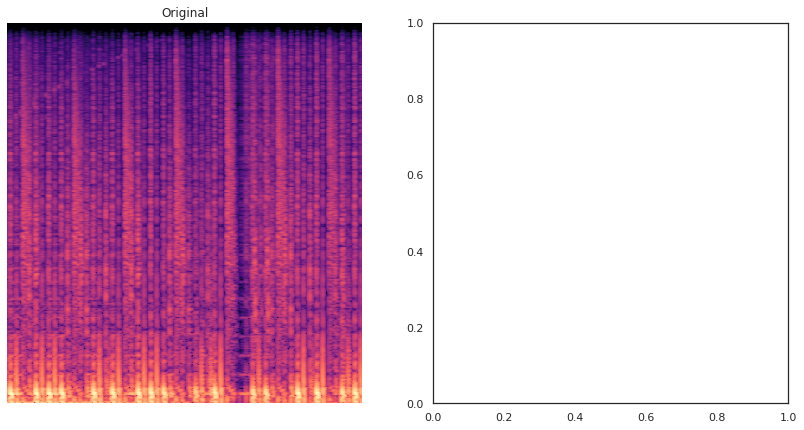

In [11]:
# Train model
model.fit_generator(
    train_dataset.take(100),
    epochs=200,
    callbacks=[tensorboard, visualizer,],
    validation_data=val_dataset.take(100),
)